# Advanced Exploratory Data Analysis
## 🧠 RSNA-MICCAI Brain Tumor Radiogenomic Classification 🧠


**Advanced Exploratory Data Analysis** and **Data Cleaning** for [RSNA-MICCAI Brain Tumor Radiogenomic Classification](https://www.kaggle.com/c/rsna-miccai-brain-tumor-radiogenomic-classification) challenge with **useful insights**, **visualizations** and **extra resources** on MRI scans.

Notebook based on the following fantastic notebooks: 
1. [
🧠Brain Tumor🧠 - EDA with Animations and Modeling](https://www.kaggle.com/ihelon/brain-tumor-eda-with-animations-and-modeling)
2. [Converting DICOM Metadata to CSV](https://www.kaggle.com/carlolepelaars/converting-dicom-metadata-to-csv-rsna-ihd-2019)
3. [DICOM Metadata EDA](https://www.kaggle.com/anarthal/dicom-metadata-eda)
4. [Pulmonary Dicom Preprocessing](https://www.kaggle.com/allunia/pulmonary-dicom-preprocessing#Prepare-to-start-) and 
5. [Insightful EDA on Meta Data & Dicom Files](https://www.kaggle.com/jagdmir/insightful-eda-on-meta-data-dicom-files).
6. [BTRC EDA (Final)](https://www.kaggle.com/josecarmona/btrc-eda-final)
7. [(Part-1) RSNA-MICCAI BTRC: Understanding The Data](https://www.kaggle.com/arnabs007/part-1-rsna-miccai-btrc-understanding-the-data)
8. [🧠 DICOM to 2D Resized Axial PNGs 256x256 [x36] 🧠](https://www.kaggle.com/smoschou55/dicom-to-2d-resized-axial-pngs-256x256-x36)

![](https://storage.googleapis.com/kaggle-competitions/kaggle/29653/logos/header.png)

<a id="top"></a>

<div class="list-group" id="list-tab" role="tablist">
<h3 class="list-group-item list-group-item-action active" data-toggle="list" style='color:white; background:darkviolet; border:0' role="tab" aria-controls="home"><center>Quick Navigation</center></h3>

* [1. Overview](#1)
* [2. Quick EDA and Data Visualization](#2)
* [3. EDA DICOM Images](#5)
* [4. EDA DICOM Metadata](#10)
* [5. EDA Pixel Data](#15)
* [6. 3D Visualizations](#20)
* [7. Conclusions](#30)
    

<a id="1"></a>
<h2 style='background:darkviolet; border:0; color:white'><center>1. Overview<center><h2>

The work uses some ideas from next great works:
- [EDA with Animation](https://www.kaggle.com/avloss/eda-with-animation) - animation technique

In [ ]:
import os
import ast
import json
import glob
import random
import collections
from tqdm import tqdm
import gc

# Visualization
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import numpy as np
import pandas as pd
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

# Seed for reproducability
seed = 1234
np.random.seed(seed)

## Files
**train/** - folder containing the training files, with each top-level folder representing a subject  
**train_labels.csv** - file containing the target MGMT_value for each subject in the training data (e.g. the presence of MGMT promoter methylation)   
**test/** - the test files, which use the same structure as train/; your task is to predict the MGMT_value for each subject in the test data. NOTE: the total size of the rerun test set (Public and Private) is ~5x the size of the Public test set   
**sample_submission.csv** - a sample submission file in the correct format

The exact mpMRI scans included are:

- Fluid Attenuated Inversion Recovery (FLAIR)
- T1-weighted pre-contrast (T1w)
- T1-weighted post-contrast (T1Gd)
- T2-weighted (T2)

Exact folder structure:


```
Training/Validation/Testing
│
└─── 00000
│   │
│   └─── FLAIR
│   │   │ Image-1.dcm
│   │   │ Image-2.dcm
│   │   │ ...
│   │   
│   └─── T1w
│   │   │ Image-1.dcm
│   │   │ Image-2.dcm
│   │   │ ...
│   │   
│   └─── T1wCE
│   │   │ Image-1.dcm
│   │   │ Image-2.dcm
│   │   │ ...
│   │   
│   └─── T2w
│   │   │ Image-1.dcm
│   │   │ Image-2.dcm
│   │   │ .....
│   
└─── 00001
│   │ ...
│   
│ ...   
│   
└─── 00002
│   │ ...
```

DICOM® — [Digital Imaging and Communications in Medicine](https://www.dicomstandard.org/about-home) — is the international standard for medical images and related information. It defines the formats for medical images that can be exchanged with the data and quality necessary for clinical use. With hundreds of thousands of medical imaging devices in use, DICOM® is one of the most widely deployed healthcare messaging Standards in the world.

## MRI Scan Basics

**1. [MRI NHS Explanation](https://www.nhs.uk/conditions/mri-scan/)**

Short bursts of radio waves are then sent to certain areas of the body, knocking the protons out of alignment.
- When the radio waves are turned off, the protons realign. This sends out radio signals, which are picked up by receivers.
- **These signals provide information about the exact location of the protons in the body.**
- **They also help to distinguish between the various types of tissue in the body, because the protons in different types of tissue realign at different speeds and produce distinct signals.**
- **In the same way that millions of pixels on a computer screen can create complex pictures, the signals from the millions of protons in the body are combined to create a detailed image of the inside of the body.**
- **Fourier Transform is used to get the final image from k-space.**

**2. [Wikipedia](https://en.wikipedia.org/wiki/Magnetic_resonance_imaging)**

 **Definitions**
- **T1-weighted**: 
The dominant signal intensities of different tissues are:
    - Lower signal for more water content, as in edema, tumor, infarction, inflammation, infection, hyperacute or chronic hemorrhage.
    - High signal for fat
    - High signal for paramagnetic substances, such as MRI contrast agents
_Standard foundation and comparison for other sequences_
- **Constrast**:
    - T1 - signal increase. Pathological tissues (tumours, areas of inflammation / infection) will demonstrate accumulation of contrast (mostly due to leaky blood vessels) and therefore appear as brighter than surrounding tissue. 
    - Often post contrast T1 sequences are also fat suppressed (see below) to make this easier to appreciate. Fat suppression (or attenuation or saturation) is a tweak performed on many T1 weighted sequences, to suppress the bright signal from fat.
- **T2-weighted**: 
    - Higher signal for more water content
    - Low signal for fat
    - Low signal for paramagnetic substances
_Standard foundation and comparison for other sequences_
- **FLAIR**:
    - Fluid suppression by setting an inversion time that nulls fluids

**3. For Intuitive MRI-scan examples see: [The Basics of MRI Interpretation](https://geekymedics.com/the-basics-of-mri-interpretation/)**

**4. For a good explanation of T1w, T1wCE, T2w, FLAIR see: [Radiopaedia: MRI sequences](https://radiopaedia.org/articles/mri-sequences-overview?lang=gb)**

**5. For a detailed list of DICOM metadata attributes and explanations see: [DICOM Attributes](https://dicom.innolitics.com/ciods/mr-image/mr-image/00181100).**

# Main Competition Workflow

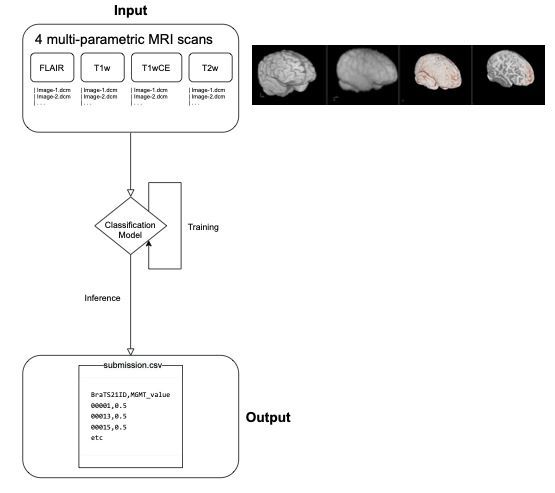

<a id="2"></a>
<h2 style='background:darkviolet; border:0; color:white'><center>2. Quick EDA and Data Visualization<center><h2>

In [ ]:
# Paths 
KAGGLE_DIR = '../input/rsna-miccai-brain-tumor-radiogenomic-classification/'
IMG_PATH_TRAIN = KAGGLE_DIR + 'train/'
IMG_PATH_TEST = KAGGLE_DIR + 'test/'
TRAIN_CSV_PATH = KAGGLE_DIR + 'train_labels.csv'
TEST_CSV_PATH = KAGGLE_DIR + 'sample_submission.csv'

### **train\** Dataset

In [ ]:
train_df = pd.read_csv(TRAIN_CSV_PATH)
display(train_df.head(5))
print('MGMT counts:')
train_df.MGMT_value.value_counts()

In [ ]:
plt.figure(figsize=(5, 5))
plt.title('Train csv')
sns.countplot(data=train_df, x="MGMT_value");

### **test\** Dataset

In [ ]:
test_df = pd.read_csv(TEST_CSV_PATH)
display(test_df.head(5))
print('MGMT counts:')
test_df.MGMT_value.value_counts()

In [ ]:
plt.figure(figsize=(5, 5))
plt.title('Test csv')
sns.countplot(data=test_df, x="MGMT_value");

In [ ]:
# All filenames for train and test images
train_images = os.listdir(IMG_PATH_TRAIN)
test_images = os.listdir(IMG_PATH_TEST)

### For more details in pixel arrays see : [Working with Pixel Data](https://pydicom.github.io/pydicom/stable/old/working_with_pixel_data.html)

In [ ]:
def load_dicom(path):
    # read file
    dicom = pydicom.read_file(path)
    # get pixel data into a useful format. 
    data = dicom.pixel_array
    # transform data into black and white scale / grayscale
    data = data - np.min(data)
    if np.max(data) != 0:
        data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
    return data


def visualize_sample(
    brats21id, 
    slice_i,
    mgmt_value,
    types=("FLAIR", "T1w", "T1wCE", "T2w")
):
    plt.figure(figsize=(16, 5))
    patient_path = os.path.join(
        IMG_PATH_TRAIN, 
        str(brats21id).zfill(5),
    )
    for i, t in enumerate(types, 1):
        t_paths = sorted(
            glob.glob(os.path.join(patient_path, t, "*")), 
            key=lambda x: int(x[:-4].split("-")[-1]),
        )
        data = load_dicom(t_paths[int(len(t_paths) * slice_i)])
        plt.subplot(1, 4, i)
        plt.imshow(data, cmap="gray")
        plt.title(f"{t}", fontsize=16)
        plt.axis("off")

    plt.suptitle(f"MGMT_value: {mgmt_value}", fontsize=16)
    plt.show()

* Visualize 10 random observations and show the 4 datasets (FLAIR, T1w, T1wCE, T2w) for each.

* Each dataset is a 3D scan / dataset and thus for simplicity visualize a specific slice for each dataset chosen by the variable $slice_i$

In [ ]:
for i in random.sample(range(train_df.shape[0]), 10): # get 10 random indexes from the train ds
    _brats21id = train_df.iloc[i]["BraTS21ID"] # for these indexes get the associated brats ID
    _mgmt_value = train_df.iloc[i]["MGMT_value"] # and tumor class
    visualize_sample(brats21id=_brats21id, mgmt_value=_mgmt_value, slice_i=0.5) # visualize samples

In [ ]:
from matplotlib import animation, rc
rc('animation', html='jshtml')


def create_animation(ims):
    fig = plt.figure(figsize=(6, 6))
    plt.axis('off')
    im = plt.imshow(ims[0], cmap="gray")

    def animate_func(i):
        im.set_array(ims[i])
        return [im]

    return animation.FuncAnimation(fig, animate_func, frames = len(ims), interval = 1000//24)

In [ ]:
def load_dicom_line(path):
    t_paths = sorted(
        glob.glob(os.path.join(path, "*")), 
        key=lambda x: int(x[:-4].split("-")[-1]),
    )
    images = []
    for filename in t_paths:
        data = load_dicom(filename)
        if data.max() == 0:
            continue
        images.append(data)
        
    return images

<a id="5"></a>
<h2 style='background:darkviolet; border:0; color:white'><center>3. EDA DICOM Images<center><h2>

In [ ]:
IMG_PATH_TRAIN = "../input/rsna-miccai-brain-tumor-radiogenomic-classification/train/"
IMG_PATH_TEST = "../input/rsna-miccai-brain-tumor-radiogenomic-classification/test/"

In [ ]:
# review training directory
s_sizes = [] # list of no. of scans present for each patient
p_sizes = [] # list of no. of dcm files present for each patient
patient_id = [] # patient id
file_paths = [] # file_paths

for d in os.listdir(IMG_PATH_TRAIN):
#     print("Patient '{}' has {} scans and a total of {} DICOM images".format(d, len(os.listdir(TRAIN_DIR + d)), len(glob.glob(TRAIN_DIR+ d + "/*/*.dcm"))))
    s_sizes.append(len(os.listdir(IMG_PATH_TRAIN + d)))
    p_sizes.append(len(glob.glob(IMG_PATH_TRAIN + d + "/*/*.dcm")))
    patient_id.append(d)

patient_files_df = pd.DataFrame(
    {'patient_id': patient_id,
     'file_count': p_sizes,
    })
    
print('----')
print('Total patients {} Total DCM files {}'.format(len(os.listdir(IMG_PATH_TRAIN)), 
                                                      len(glob.glob(IMG_PATH_TRAIN+ "/*/*/*.dcm"))))

print('----')
print('TRAIN Dataframe with File Count per Patient ')
display(patient_files_df.head(5))

print('----')
print('Verify total File Count for all Patients ')
print('Total number of patients:', patient_files_df.shape[0])

print('Total file count:', patient_files_df.file_count.sum())

In [ ]:
f = []
for (dirpath, dirnames, filenames) in os.walk(IMG_PATH_TRAIN):
    f.extend(os.path.join(dirpath, x) for x in filenames)
    
train_file_paths_df = pd.DataFrame({'file_paths': f})
train_file_paths_df['train_dir'] = IMG_PATH_TRAIN
train_file_paths_df['patient_id'] = train_file_paths_df['file_paths'].str.split("/", n = 7, expand = True)[4]
train_file_paths_df['scan_type'] = train_file_paths_df['file_paths'].str.split("/", n = 7, expand = True)[5]
train_file_paths_df['file'] = train_file_paths_df['file_paths'].str.split("/", n = 7, expand = True)[6]
display(train_file_paths_df.head(2))
train_file_paths_df.shape[0]

**train/ dataset:** 

We have a total of 585 directories, one for each patient, with 4 subdirectories corresponding to 4 scans per patient and total of 348641 dicom images

In [ ]:
print('Possible Number of scans for all patients:', set(s_sizes))

So all patients in the train/ ds had all 4 types of scans: T1w, T1wCE, T2w, FLAIR.

In [ ]:
# lets visualize trainig data
p = sns.color_palette()
plt.hist(p_sizes, color=p[2])
plt.ylabel('Number of patients')
plt.xlabel('Count of DICOM files')
plt.title('Histogram of DICOM count per patient - Training Data');

In [ ]:
# review test directory
s_sizes = [] # list of no. of scans present for each patient
p_sizes = [] # list of no. of dcm files present for each patient
patient_id = [] # patient id

for d in os.listdir(IMG_PATH_TEST):
#     print("Patient '{}' has {} scans and a total of {} DICOM images".format(d, 
#                     len(os.listdir(IMG_PATH_TEST + d)), len(glob.glob(IMG_PATH_TEST+ d + "/*/*.dcm"))))
    s_sizes.append(len(os.listdir(IMG_PATH_TEST + d)))
    p_sizes.append(len(glob.glob(IMG_PATH_TEST + d + "/*/*.dcm")))
    patient_id.append(d)

patient_files_df = pd.DataFrame(
    {'patient_id': patient_id,
     'file_count': p_sizes,
    })
    
print('----')
print('Total patients {} Total DCM files {}'.format(len(os.listdir(IMG_PATH_TEST)), 
                                                      len(glob.glob(IMG_PATH_TEST+ "/*/*/*.dcm"))))
print('----')
print('TRAIN Dataframe with File Count per Patient ')
display(patient_files_df.head(5))

print('----')
print('Verify total File Count for all Patients ')
print('Total number of patients:', patient_files_df.shape[0])

print('Total file count:', patient_files_df.file_count.sum())

In [ ]:
f = []
for (dirpath, dirnames, filenames) in os.walk(IMG_PATH_TEST):
    f.extend(os.path.join(dirpath, x) for x in filenames)
    
test_file_paths_df = pd.DataFrame({'file_paths': f})
test_file_paths_df['train_dir'] = IMG_PATH_TEST
test_file_paths_df['patient_id'] = test_file_paths_df['file_paths'].str.split("/", n = 7, expand = True)[4]
test_file_paths_df['scan_type'] = test_file_paths_df['file_paths'].str.split("/", n = 7, expand = True)[5]
test_file_paths_df['file'] = test_file_paths_df['file_paths'].str.split("/", n = 7, expand = True)[6]
display(test_file_paths_df.head(2))
test_file_paths_df.shape[0]

**test/ dataset:** 

We have a total of 87 directories, one for each patient, with 4 subdirectories corresponding to 4 scans per patient and total of 51473 dicom images, i.e. **about 13% and 87% test / train split**. 

In [ ]:
print('Possible Number of scans for all patients:', set(s_sizes))

So all patients in the test/ ds had all 4 types of scans: T1w, T1wCE, T2w, FLAIR.

In [ ]:
# lets visualize test data
p = sns.color_palette()
plt.hist(p_sizes, color=p[2])
plt.ylabel('Number of patients')
plt.xlabel('Count of DICOM files')
plt.title('Histogram of DICOM count per patient - Training Data');

# Let's check the size of the dicom images

In [ ]:
# sizes = [os.path.getsize(dcm)/1000000 for dcm in glob.glob(TRAIN_DIR+ "/*/*/*.dcm")]
# print('DCM file sizes: min {:.3}MB max {:.3}MB avg {:.3}MB std {:.3}MB'.format(np.min(sizes), 
#                                                        np.max(sizes), np.mean(sizes), np.std(sizes)))

The DICOM files in the **\train** dataset have sizes between 0.1MB and 2.1MB (average 0.34MB).

Result: DCM file sizes: min 0.0991MB max 2.08MB avg 0.341MB std 0.202MB

# Peek at one example dicom-file 

The [pydicom](https://pydicom.github.io/pydicom/stable/getting_started.html) library allows us to conveniently read in DICOM files and access different values from the file. The actual image can be found in "pixel_array".

In [ ]:
print('Example of all data in a single DICOM file:\n')
example_dicom = pydicom.dcmread(train_file_paths_df['file_paths'][0])
print(example_dicom)

<a id="10"></a>
<h2 style='background:darkviolet; border:0; color:white'><center>4. EDA DICOM Metadata<center><h2>

In [ ]:
# All columns for which we want to collect information
meta_cols = ['SpecificCharacterSet','ImageType','SOPClassUID',
             'SOPInstanceUID','AccessionNumber','Modality', 'SeriesDescription', 
             'PatientID', 'MRAcquisitionType', 'SliceThickness', 
             'EchoTime', 'NumberOfAverages', 'ImagingFrequency', 'ImagedNucleus', 
             'MagneticFieldStrength', 'SpacingBetweenSlices', 
             'EchoTrainLength', 'PercentSampling', 'PercentPhaseFieldOfView',
             'PixelBandwidth', 'TriggerWindow', 'ReconstructionDiameter', 'AcquisitionMatrix',
             'FlipAngle', 'SAR', 'PatientPosition',
             'StudyInstanceUID', 'SeriesInstanceUID', 'SeriesNumber', 'InstanceNumber',
             'ImagePositionPatient', 'ImageOrientationPatient', 'Laterality',
             'PositionReferenceIndicator', 'SliceLocation', 'InStackPositionNumber',
             'SamplesPerPixel', 'PhotometricInterpretation', 'Rows', 'Columns', 'PixelSpacing',
             'BitsAllocated', 'BitsStored', 'HighBit', 'PixelRepresentation', 'WindowCenter',
             'WindowWidth', 'RescaleIntercept', 'RescaleSlope', 'RescaleType']

In [ ]:
# Initialize dictionaries to collect the metadata
col_dict_train = {col: [] for col in meta_cols}
col_dict_test = {col: [] for col in meta_cols}

Here we extract all features for the training and testing set.

❗❗❗ **If you want to create the collactive metadata dataframes for test and train datasets from the DICOM images within the directory tree, you can uncomment the following three code snipets / cells.** ❗❗❗

🏎   To speed things up I skip this step here, as it takes O(hours) and I have already done this once and loaded the train and test metadata *.csv files as input.

In [ ]:
'''Uncomment code snipet to obtain metadata for all train DICOM images'''
# # Get values for training images
# for img in tqdm(train_file_paths_df.file_paths): 
#     dicom_object = pydicom.dcmread(img)
#     for col in meta_cols: 
# #         print(str(getattr(dicom_object, col)))
#         try:
#             col_dict_train[col].append(str(getattr(dicom_object, col)))
#         except AttributeError:
#             col_dict_train[col].append("NaN")

# # Store all information in a DataFrame
# meta_df_train = pd.DataFrame(col_dict_train)
# del col_dict_train
# # Garbage Collector for memory cleaning
# gc.collect()

In [ ]:
'''Uncomment code snipet to obtain metadata for all test DICOM images'''
# # Get values for training images
# for img in tqdm(test_file_paths_df.file_paths): 
#     dicom_object = pydicom.dcmread(img)
#     for col in meta_cols: 
# #         print(str(getattr(dicom_object, col)))
#         try:
#             col_dict_test[col].append(str(getattr(dicom_object, col)))
#         except AttributeError:
#             col_dict_test[col].append("NaN")

# # Store all information in a DataFrame
# meta_df_test = pd.DataFrame(col_dict_test)
# del col_dict_test
# # Garbage Collector for memory cleaning
# gc.collect()

 Save metadata dataframes to *.csv files so that we don't have to redo this long computation.

In [ ]:
'''Uncomment code snipet to store metadata dataframes for test and train dfs'''
# # Save to CSV
# meta_df_train.to_csv('stage_0_train_with_metadata.csv', index=False)
# meta_df_test.to_csv('stage_0_test_with_metadata.csv', index=False)

## Load Metadata for train/ and test/ and do EDA for insights

In [ ]:
test_meta_df = pd.read_csv("../input/stage0-metadata-rsna/stage_0_test_with_metadata.csv")
train_meta_df = pd.read_csv("../input/stage0-metadata-rsna/stage_0_train_with_metadata.csv")

### Insights on Metadata

Calculate unique number of values per metadata attribute.

### train/ dataset

In [ ]:
meta_attr = []
num_unique = []

for col in train_meta_df:
#     print("* For attribute  '{}' , there are [ {} ] unique values.".format(col,
#                     len(train_meta_df[col].unique())))
    meta_attr.append(col)
    num_unique.append(len(train_meta_df[col].unique()))
    
train_meta_values_df = pd.DataFrame(
    {'attribute': meta_attr,
     'value_count': num_unique,
     'nan_count': train_meta_df.isna().sum()
    })

train_meta_values_df = train_meta_values_df.sort_values(by=['value_count'], ascending=False).reset_index(drop=True)
train_meta_values_df

There are 50 attributes present in the DICOM images of the **train/  - dataset** and 585 unique patients.

### test/ dataset

In [ ]:
meta_attr = []
num_unique = []

for col in test_meta_df:
#     print("* For attribute  '{}' , there are [ {} ] unique values.".format(col,
#                     len(train_meta_df[col].unique())))
    meta_attr.append(col)
    num_unique.append(len(test_meta_df[col].unique()))
    
test_meta_values_df = pd.DataFrame(
    {'attribute': meta_attr,
     'value_count': num_unique,
     'nan_count': test_meta_df.isna().sum()
    })

test_meta_values_df = test_meta_values_df.sort_values(by=['value_count'], ascending=False).reset_index(drop=True)
test_meta_values_df

There are 50 attributes present in the DICOM images of the **test/  - dataset** and 87 unique patients.

### train/ - dataset

In [ ]:
def color_code_by_vcount(df):
    if df['value_count'] == 1.0:
        return 'k' # Single unique value, color-code black
    elif df['value_count'] <= 1000.0:
        return 'b' # Unique value count between one and 1000, color-code blue
    else:
        return 'r' # Unique value count more than > 1000, color-code red

train_mv_df = train_meta_values_df.copy().set_index("attribute")
train_mv_df['color'] = train_mv_df.apply(color_code_by_vcount, axis=1)

ax = train_mv_df['value_count'].plot(kind='bar',
                                    figsize=(14,8),  color=train_mv_df['color'],
                                    title="Number of Unique Values per Attribute [LOG SCALE]")
ax.set_xlabel("Metadata Attribute")
ax.set_ylabel("Unique Number of Values [LOG SCALE]")
ax.set_yscale('log');

We are **probably** interested in the **blue-range** attributes mainly since, highly-unique and single value attributes, will not help learn new information that will help our model discriminate between different cases during training.

### 4.1 NAN count

In [ ]:
f, axes = plt.subplots(1, 2, figsize=(15,15))

nans = train_meta_df.isna().sum().sort_values(ascending=False)
sns.barplot(y=nans.index, x=nans, orient='h', ax = axes[0])
axes[0].set_title("Train NaN Count")

nans_test = test_meta_df.isna().sum().sort_values(ascending=False)
sns.barplot(y=nans_test.index, x=nans_test, orient='h', ax = axes[1])
axes[1].yaxis.set_ticks_position("right")
axes[1].set_title("Test NaN Count");

### 4.2 Let's try merging train/ and test/ to gain some more insights

In [ ]:
merged_meta_attrs = pd.merge(train_meta_values_df, test_meta_values_df, on="attribute", 
                             suffixes=("_train","_test"))
merged_meta_attrs

* AccessionNumber, PatientID and StudyInstanceUID seem to be unique per patient as there are 585 and 87 unique values for **train/** and **test/** datasets, i.e. as many patients there are in each ds respectively. So we can either drop them all and only keep PatientID as the patient identifier.

* There are some descrepancy between test and train value counts.

In [ ]:
'''Print attributes unique values for low value count and descrepancy between test and train.'''
print(train_meta_df["SpecificCharacterSet"].unique())
print(test_meta_df["PositionReferenceIndicator"].unique())

There are not any other obvious descrepancies between **train\** and **test\** from the value count, so we will continue looking into the train data for more insights below.

### In conclusion so far we can drop the following metadata attributes, since they probably won't help our model:
* SOPInstanceUID
* ImagePositionPatient
* SliceLocation
* WindowWidth
* WindowCenter
* SeriesInstanceUID
* SAR
* ImageOrientationPatient
* ImagingFrequency
* AccessionNumber
* StudyInstanceUID
* HighBit
* RescaleIntercept
* BitsStored
* BitsAllocated
* RescaleSlope
* PatientPosition
* PhotometricInterpretation
* SamplesPerPixel
* PositionReferenceIndicator
* Laterality
* ImageType
* SpacingBetweenSlices
* Modality
* SOPClassUID
* RescaleType

So we are left with the following columns

In [ ]:
list_drop_attrs = ["SOPInstanceUID","ImagePositionPatient","SliceLocation","WindowWidth",
                   "WindowCenter","SeriesInstanceUID","SAR","ImageOrientationPatient",
                   "ImagingFrequency","AccessionNumber","StudyInstanceUID","HighBit",
                   "RescaleIntercept","BitsStored","BitsAllocated","RescaleSlope",
                   "PatientPosition","PhotometricInterpretation","SamplesPerPixel",
                   "PositionReferenceIndicator","Laterality",'ImageType',"SpacingBetweenSlices",
                   "Modality","SOPClassUID","RescaleType",]

In [ ]:
print("Columns before : ", len(train_meta_df.columns))
train_meta_df_useful = train_meta_df.drop(list_drop_attrs, axis=1)
print("Columns after : ", len(train_meta_df_useful.columns))

### 4.3 Image sizes

**Definitions from [DICOM Standard Website](https://dicom.innolitics.com/ciods)**
* [Rows](https://dicom.innolitics.com/ciods/us-image/image-pixel/00280010): Number of rows in the image.Shall be an exact multiple of the vertical downsampling factor if any of the samples (planes) are encoded downsampled in the vertical direction for pixel data encoded in a Native (uncompressed) format. E.g., required to be an even value for a Photometric Interpretation (0028,0004) of YBR_FULL_422.

* [Columns](https://dicom.innolitics.com/ciods/us-image/image-pixel/00280011): Number of columns in the image. Shall be an exact multiple of the horizontal downsampling factor if any of the samples (planes) are encoded downsampled in the horizontal direction for pixel data encoded in a Native (uncompressed) format. E.g., required to be an even value for a Photometric Interpretation (0028,0004) of YBR_FULL_422.

In [ ]:
sizes = train_meta_df.apply(lambda x: f'{x.Rows}x{x.Columns}', axis=1)
plt.figure(figsize=(15, 8))
plt.xticks(rotation=45)
sns.countplot(sizes);

### 4.4 Series Description

**Definitions from [DICOM Standard Website](https://dicom.innolitics.com/ciods)**
* [Series Description](https://dicom.innolitics.com/ciods/segmentation/general-series/0008103e): Description of Series. Long String (LO). 

In our case: T1w, T1wCE, T2w, FLAIR

In [ ]:
sns.countplot(train_meta_df.SeriesDescription);

### 4.5 Slice Thickness

**Definitions from [DICOM Standard Website](https://dicom.innolitics.com/ciods)**
* [Slice Thickness](https://dicom.innolitics.com/ciods/ct-image/image-plane/00180050): Nominal slice thickness, in mm. 
* [Spacing Between Slices](https://dicom.innolitics.com/ciods/mr-image/mr-image/00180088): Spacing between slices, in mm. The spacing is measured from the center-to-center of each slice.

In [ ]:
plt.figure(figsize=(12, 5))
plt.xticks(rotation=45)
sns.countplot(train_meta_df.SliceThickness);

In [ ]:
sns.jointplot(data=train_meta_df, x='SliceThickness', y='SpacingBetweenSlices');

### 4.6 MR Acquisition Type

**Definitions from [DICOM Standard Website](https://dicom.innolitics.com/ciods)**
* [MR Acquisition Type
](https://dicom.innolitics.com/ciods/mr-image/mr-image/00180023): Identification of data encoding scheme.Enumerated Values
    * 2D: frequency x phase
    * 3D: frequency x phase x phase

In [ ]:
sns.countplot(train_meta_df.MRAcquisitionType);

### 4.7 Number Of Averages

**Definitions from [DICOM Standard Website](https://dicom.innolitics.com/ciods)**
* [Number Of Averages](https://dicom.innolitics.com/ciods/mr-image/mr-image/00180083): Number of times a given pulse sequence is repeated before any parameter is changed.

In [ ]:
sns.countplot(train_meta_df.NumberOfAverages);

### 4.8 MagneticFieldStrength

**Definitions from [DICOM Standard Website](https://dicom.innolitics.com/ciods)**
* [Magnetic Field](https://dicom.innolitics.com/ciods/mr-image/mr-image/00180087): Nominal field strength of MR magnet, in Tesla.
Example Values:
    * 15000 😱😱😱
    * 1.5
    * 3


In [ ]:
sns.countplot(train_meta_df.MagneticFieldStrength);

### 4.9 Reconstruction Diameter

**Definitions from [DICOM Standard Website](https://dicom.innolitics.com/ciods)**
* [Reconstruction Diameter](https://dicom.innolitics.com/ciods/nm-image/nm-reconstruction/00181100): Diameter, in mm, of the region from within which the data was used in creating the reconstruction of the image. Data may exist outside this region and portions of the patient may exist outside this region. The diameter defines a circular region that is entirely contained within the encoded Pixel Data (7FE0,0010), unless the encoded image has been cropped after reconstruction.

**_Note_**
If not cropped or padded, for square images with square pixels, both values of Pixel Spacing (0028,0030) will be equal and equal to Reconstruction Diameter (0018,1100) / Rows (0028,0010) and Reconstruction Diameter (0018,1100) / Columns (0028,0011). 

In [ ]:
plt.figure(figsize=(12, 5))
plt.xticks(rotation=45)
sns.countplot(train_meta_df.ReconstructionDiameter);

### 4.10 Pixel Representation

**Definitions from [DICOM Standard Website](https://dicom.innolitics.com/ciods)**
* [Pixel Representation](https://dicom.innolitics.com/ciods/segmentation/image-pixel/00280103): Data representation of the pixel samples. Each sample shall have the same pixel representation.
Enumerated Values:
    * 0000H: unsigned integer.
    * 0001H: 2's complement. 

In [ ]:
len(train_meta_df.PixelRepresentation.unique())

In [ ]:
sns.countplot(train_meta_df.PixelRepresentation);

### 4.11 Pixel Representation

**Definitions from [DICOM Standard Website](https://dicom.innolitics.com/ciods)**
* [Image Orientation](https://dicom.innolitics.com/ciods/mr-image/image-plane/00200037) (0020,0037) specifies the direction cosines of the first row and the first column with respect to the patient. These Attributes shall be provide as a pair. Row value for the x, y, and z axes respectively followed by the Column value for the x, y, and z axes respectively.
_The direction of the axes is defined fully by the patient's orientation._

Get Orientation of each Image from coordinates [x1,y1,x2,y2] to coronal, axial or sagittal.

In [ ]:
def get_image_plane(data):
    '''
    Returns the MRI's plane from the dicom data.
    
    '''
    x1,y1,_,x2,y2,_ = [round(j) for j in ast.literal_eval(data.ImageOrientationPatient)]
    cords = [x1,y1,x2,y2]

    if cords == [1,0,0,0]:
        return 'coronal'
    if cords == [1,0,0,1]:
        return 'axial'
    if cords == [0,1,0,0]:
        return 'sagittal'
    
train_meta_df['Orientation'] = train_meta_df.apply(get_image_plane, axis=1)

test_meta_df['Orientation'] = test_meta_df.apply(get_image_plane, axis=1)

Overall Orientation Distribution

**/train/ dataset**

In [ ]:
sns.countplot(train_meta_df.Orientation);

count: "axial" > "sagittal" > "coronal"

**/test - dataset**

In [ ]:
sns.countplot(test_meta_df.Orientation);

❗❗❗ SAME AS FOR TRAIN ❗❗❗(Confusing Colors)

count: "axial" > "sagittal" > "coronal"

Orientation Distribution per Scan Type

In [ ]:
sns.histplot(data=train_meta_df, x="SeriesDescription", hue="Orientation", 
             multiple="dodge", shrink=.8);

In [ ]:
sns.histplot(data=test_meta_df, x="SeriesDescription", hue="Orientation", 
             multiple="dodge", shrink=.8);

* Similar Distributions for both Train and Test.
* T2w has more sagittal images.
* FLAIR more coronal
* T1w and T1wCE many more axial.

**Let's see if all images per patient and per modality have the same orientation**

In [ ]:
df2 = train_meta_df.groupby(['PatientID', 'Orientation', 'SeriesDescription']).size().reset_index(name='count') 
df2

In [ ]:
len(df2.PatientID.unique()) * 4

Indeed for each patient the orientations of images within each modality do not change.

In [ ]:
dft = test_meta_df.groupby(['PatientID', 'Orientation', 'SeriesDescription']).size().reset_index(name='count') 
dft

In [ ]:
len(dft.PatientID.unique()) * 4

Same goes for the test dataset.

### 4.12 Heatmap

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))   
sns.heatmap(train_meta_df.corr(), ax =ax)

Not very interesting patterns in term of metadata feature correlation.

<a id="15"></a>
<h2 style='background:darkviolet; border:0; color:white'><center>5. EDA Pixel Data<center><h2>

Plot Histogram of Pixel Values per Image

## Histogram of Raw Image Data

In [ ]:
def image_stats(image):
    nonzero_pixels = image[np.nonzero(image)]
    if nonzero_pixels.shape == (0,):
        mean = 0
        std = 0
    else:
        mean = np.mean(nonzero_pixels)
        std = np.std(nonzero_pixels)
    return (mean,std)

def plot_image_hist(image, threshold = 1.5, normalize = False):
    pixels = image.ravel()
    nonzero_pixels = pixels[np.nonzero(pixels)]
    (mean,std) = image_stats(nonzero_pixels)
    if normalize:
        nonzero_pixels = (nonzero_pixels - mean) / std
        (mean,std) = image_stats(nonzero_pixels)
    over_threshold = np.count_nonzero(nonzero_pixels > mean + threshold * std)

    fig, (axi, axh) = plt.subplots(1, 2, figsize = (20,3), 
                                   gridspec_kw={'width_ratios': [1, 4]})
    fig.suptitle(f'Pixels over threshold # ({over_threshold})')

    axh.hist(nonzero_pixels, 200)

    ax_limits = axh.get_ylim()
    axh.vlines(mean, ymin=ax_limits[0], 
               ymax=ax_limits[1], colors='b')
    axh.vlines(mean+std, ymin=ax_limits[0], 
               ymax=ax_limits[1], colors='b', linestyles='dotted')
    axh.vlines(mean + threshold * std, ymin=ax_limits[0], 
               ymax=ax_limits[1], colors='b', linestyles='dashed')
    axi.imshow(image, cmap = plt.cm.gray)
    axi.grid(False)
    axi.axis('off')
    plt.show()

Plot DICOM image and pixel value distributions next to each other.

In [ ]:
img = load_dicom("../input/rsna-miccai-brain-tumor-radiogenomic-classification/train/00000/T2w/Image-200.dcm")
plot_image_hist(img, threshold = 2, normalize = True)

In [ ]:
plot_image_hist(img, threshold = 2, normalize = False)

Visualize the histogram distribution of all the scans for a random patient ID.

In [ ]:
def visualize_hist_sample_image(
    brats21id, 
    slice_i,
    mgmt_value,
    types=("FLAIR", "T1w", "T1wCE", "T2w"),
    threshold = 1.5, normalize = False
):
    plt.figure(figsize=(16, 5))
    patient_path = os.path.join(
        IMG_PATH_TRAIN, 
        str(brats21id).zfill(5),
    )
    for i, t in enumerate(types, 1):
        t_paths = sorted(
            glob.glob(os.path.join(patient_path, t, "*")), 
            key=lambda x: int(x[:-4].split("-")[-1]),
        )
        image = load_dicom(t_paths[int(len(t_paths) * slice_i)])
        pixels = image.ravel()
        nonzero_pixels = pixels[np.nonzero(pixels)]
        (mean,std) = image_stats(nonzero_pixels)
        if normalize:
            nonzero_pixels = (nonzero_pixels - mean) / std
            (mean,std) = image_stats(nonzero_pixels)
        over_threshold = np.count_nonzero(nonzero_pixels > mean + threshold * std)

        fig, (axi, axh) = plt.subplots(1, 2, figsize = (20,3), 
                                       gridspec_kw={'width_ratios': [1, 4]});

        axh.hist(nonzero_pixels, 200)

        ax_limits = axh.get_ylim()
        axh.vlines(mean, ymin=ax_limits[0], 
                   ymax=ax_limits[1], colors='b')
        axh.vlines(mean+std, ymin=ax_limits[0], 
                   ymax=ax_limits[1], colors='b', linestyles='dotted')
        axh.vlines(mean + threshold * std, ymin=ax_limits[0], 
                   ymax=ax_limits[1], colors='b', linestyles='dashed')
        axi.imshow(image, cmap = plt.cm.gray)
        axi.grid(False)
        plt.title(f"{t}: pixels over threshold # ({over_threshold})", fontsize=16)
        axi.axis('off')
#     plt.suptitle(f"MGMT_value: {mgmt_value}", fontsize=16)
    plt.show()
    print(f"MGMT_value: {mgmt_value}")

In [ ]:
for i in random.sample(range(train_df.shape[0]), 2): # get 10 random indexes from the train ds
    _brats21id = train_df.iloc[i]["BraTS21ID"] # for these indexes get the associated brats ID
    _mgmt_value = train_df.iloc[i]["MGMT_value"] # and tumor class
    visualize_hist_sample_image(brats21id=_brats21id, mgmt_value=_mgmt_value, slice_i=0.5,
                           threshold = 2, normalize = True) # visualize samples

Different scans have different histogram distributions as they focus and capture different pathological features.

## Mask and Plot Image Data

In [ ]:
def visualize_masked_sample(
    brats21id, 
    slice_i,
    mgmt_value,
    types=("FLAIR", "T1w", "T1wCE", "T2w"),
    threshold = -1
):
    plt.figure(figsize=(16, 5))
    patient_path = os.path.join(
        IMG_PATH_TRAIN, 
        str(brats21id).zfill(5),
    )
    for i, t in enumerate(types, 1):
        t_paths = sorted(
            glob.glob(os.path.join(patient_path, t, "*")), 
            key=lambda x: int(x[:-4].split("-")[-1]),
        )
        data = load_dicom(t_paths[int(len(t_paths) * slice_i)])
        if threshold > -1:
            data[data < threshold] = 0
        plt.subplot(1, 4, i)
        plt.imshow(data, cmap="gray")
        plt.title(f"{t}", fontsize=16)
        plt.axis("off")

    plt.suptitle(f"MGMT_value: {mgmt_value}", fontsize=16)
    plt.show()

Randomly choose a case to visualize and explore whether a threshold can be applied.

In [ ]:
i = 520
_brats21id = train_df.iloc[i]["BraTS21ID"] # for these indexes get the associated brats ID
_mgmt_value = train_df.iloc[i]["MGMT_value"] # and tumor class
visualize_sample(brats21id=_brats21id, mgmt_value=_mgmt_value, slice_i=0.5) # visualize samples

Replace with zeros all pixels with values below a threshold.

In [ ]:
i = 520
_brats21id = train_df.iloc[i]["BraTS21ID"] # for these indexes get the associated brats ID
_mgmt_value = train_df.iloc[i]["MGMT_value"] # and tumor class
visualize_masked_sample(brats21id=_brats21id, mgmt_value=_mgmt_value, slice_i=0.4,
                           threshold = 80) # visualize samples

Replace with zeros all pixels with values below a larger threshold.

In [ ]:
i = 520
_brats21id = train_df.iloc[i]["BraTS21ID"] # for these indexes get the associated brats ID
_mgmt_value = train_df.iloc[i]["MGMT_value"] # and tumor class
visualize_masked_sample(brats21id=_brats21id, mgmt_value=_mgmt_value, slice_i=0.5,
                           threshold = 120) # visualize samples

It's difficult to find and apply a lower threshold in each image in order to isolate the tumor and remove non-important features, as there is no single threshold that fits all the kinds of scans. This is because especially T1wCE is bright overall when the majority of features of FLAIR and T2w appear darker. The reason for this is that each of the different scan types capture and give emphasis on different pathological/anatomical structures.

## Image Pixel Data Stats

For this part we make use of image statistical properties and [this dataset](https://www.kaggle.com/smoschou55/train-test-filepaths-rsna-full) produced using [this notebook](https://www.kaggle.com/smoschou55/dicom-to-2d-resized-axial-pngs-256x256-x36).

In [ ]:
train_px_df = pd.read_csv('/kaggle/input/train-test-filepaths-rsna-full/stats_train_file_paths_df.csv')
test_px_df = pd.read_csv('/kaggle/input/train-test-filepaths-rsna-full/stats_test_file_paths_df.csv')

**\train**

In [ ]:
stats_cols = []
num_unique = []

for col in train_px_df:
#     print("* For attribute  '{}' , there are [ {} ] unique values.".format(col,
#                     len(train_meta_df[col].unique())))
    stats_cols.append(col)
    num_unique.append(len(train_px_df[col].unique()))
    
train_df_stats = pd.DataFrame(
    {'col_name': stats_cols,
     'value_count': num_unique,
     'nan_count': train_px_df.isna().sum()
    })

train_df_stats = train_df_stats.sort_values(by=['value_count'], ascending=False).reset_index(drop=True)
train_df_stats = train_df_stats.set_index('col_name').T
train_df_stats

**\test**

In [ ]:
stats_cols = []
num_unique = []

for col in test_px_df:
#     print("* For attribute  '{}' , there are [ {} ] unique values.".format(col,
#                     len(train_meta_df[col].unique())))
    stats_cols.append(col)
    num_unique.append(len(test_px_df[col].unique()))
    
test_df_stats = pd.DataFrame(
    {'col_name': stats_cols,
     'value_count': num_unique,
     'nan_count': test_px_df.isna().sum()
    })

test_df_stats = test_df_stats.sort_values(by=['value_count'], ascending=False).reset_index(drop=True)
test_df_stats = test_df_stats.set_index('col_name').T
test_df_stats

**Min and Max values for all Images in Train and Test**

In [ ]:
print(train_px_df.min_px.unique(), train_px_df.max_px.unique())
print(test_px_df.min_px.unique(), test_px_df.max_px.unique())

- We confirm that the images have been normalized between [0, 255].
- All images have min value 0 and max value either min=max=0 or max=255.

The normalization has taken place within the notebook: [🧠 DICOM to 2D Resized Axial PNGs 256x256 [x36] 🧠](https://www.kaggle.com/smoschou55/dicom-to-2d-resized-axial-pngs-256x256-x36) in order to draw useful conclusions and make meaningful comparisons.

In [ ]:
min(train_px_df.mean_px.unique()), max(train_px_df.mean_px.unique())

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(25, 8), sharey=True)
fig.suptitle('Train - Test Dataset Pixel Distributions Mean + STD')

sns.histplot(ax=axes[0], data = train_px_df[['mean_px', 'std_px']], bins=50, alpha=0.5)
axes[0].set_yscale('log')
sns.histplot(ax=axes[1], data = test_px_df[['mean_px', 'std_px']], bins=50, alpha=0.5)
plt.show();

- Train and test images follow similar distributions with respect the mean and standard deviation.
- Test_mean = train_mean - 20 and test_std = train_std - 20.

### Take a look into distribution per scan type

**/train**

In [ ]:
g = sns.FacetGrid(train_px_df, col="scan_type")
g.map(plt.hist, 'mean_px', bins=50);
g.set(yscale="log")

With respect to pixel values we see that:
- All scans peak at mean = 0, i.e. there are many empty slices.
- T2w distribution peaks at mean = 20 and almost cuts off at 60, with low values up to 100.
- T1wCE is similar to T2w with the difference that the peak at value 20 is rounder and wider.
- T1w is thicker and more uniform with a sharp cutoff at value 100.
- FLAIR distribution is similar to T2w with a peak at 30 and a thicker tail that cutsoff at 80 with low values up to 100.

**/test**

In [ ]:
g = sns.FacetGrid(test_px_df, col="scan_type")
g.map(plt.hist, 'mean_px', bins=50);
g.set(yscale="log")

- Similar to **/train** with the difference that cutsoff are all value 20 less than train cut off values.
- Peaks remain in the same places as train peaks.

### Look into label differences

In [ ]:
train_lbls = pd.read_csv(TRAIN_CSV_PATH)

In [ ]:
train_px_df = train_px_df.merge(train_lbls, left_on='patient_id', right_on='BraTS21ID')
train_px_df.head(2)

In [ ]:
g = sns.FacetGrid(train_px_df, col="scan_type", hue='MGMT_value')
g.map(plt.hist, 'mean_px', bins=50, alpha=0.5);
g.set(yscale="log")
g.add_legend()

Interestingly, there are some noticeable differences between the distributions of pixels between patients with MGMT_value 0 and MGMT_value 1.
- Images of Patients with MGMT methylation, have larger peaks for T2w, T1wCE and FLAIR. This could be due to some number difference between slices in the two groups.
- And most importantly, Images of Patients with MGMT methylation have consistently larger mean values for scan types T2w, T1wCE and FLAIR.
- T1w distributions for both MGMT 0 and 1 groups are almost indiscriminate.

<a id="20"></a>
<h2 style='background:darkviolet; border:0; color:white'><center>6. 3D Visualizations<center><h2>

## Load 3D DICOM files and create animations with them

TBD : Work in Progress

In [ ]:
images = load_dicom_line(IMG_PATH_TRAIN + "00000/FLAIR")
create_animation(images)

In [ ]:
images = load_dicom_line(IMG_PATH_TRAIN + "00000/T1w")
create_animation(images)

In [ ]:
images = load_dicom_line(IMG_PATH_TRAIN + "00000/T1wCE")
create_animation(images)

In [ ]:
images = load_dicom_line(IMG_PATH_TRAIN + "00000/T2w")
create_animation(images)

<a id="30"></a>
<h2 style='background:darkviolet; border:0; color:white'><center>7. Conclusions<center><h2>

In general:

**This compeition contains some highly consistent data, with well-balanced distributions between train and test datasets and with very informative matadata that correspond to the actual values, ot the extend investigated in this notebook.**

Minor points to be careful with and that are not expected to affect the data handling and modeling part:
* There seem to be both 3D and 2D labeled MR Acquisition Types. I don't expect this to have any impact on modeling though, as there still are 2D slices comprising a 3D volume of a brain.
* There is a magnetic field intensity 15000 suposedly in Tesla, but that is most probably a typo meaning 15000 Gauss which is equal to 1.5 Tesla.

Specific comments:
* There is no class imbalance between positive and negative class in the train dataset, i.e. half of the train do show MGMT methylation and half do not.
* There several images that have very small parts of the brain or nothing at all captured and these are expected to not play a major role in the classification task later on, so could be removed as a first order approach.
* Spacing resolution seems to be the same for all images, i.e. Spacing Between Slices is 1mm.
* Most images are of size 512x512, but sizes can vary significantly, so resazing is going to be necessary for most ML algorithms.
* There are at laeast about 80,000 images per each one of the T1w, T1wCE, T2w, FLAIR modalities
* Overall there are more axial images than sagittal and way more than coronal (more on [MRI Planes in this notebook section](https://www.kaggle.com/arnabs007/part-1-rsna-miccai-btrc-understanding-the-data/comments?scriptVersionId=70970330&cellId=18))
* The dominant orientations strongly vary between the different modalities. This needs to be considered in 2D modeling efforts or when combining the different modalities in preprocessing for example. More specifically,
    * T2w dominant oriantation is saggital
    * FLAIR dominant orientation is coronal and
    * T1w and T1wCE dominant orientation is axial.
* Train and Test datasets follow similar trends in terms of orientation and most features explored herein.
* For each patient the orientations of images within each modality do not change.
* Tumors appear bright in FLAIR and T2w, less bright in T1wCE, and not bright at all in T1w. Histograms reflect this as well, with different modalities having their peaks and being skewed towards different directions. This needs to be considered if one wants to apply a low limit on pixel intensity to remove non-informative pixels. There is no single threshold that fits all.
* Interestingly, there are some noticeable differences between the mean distributions of pixels between patients with MGMT_value 0 and MGMT_value 1.
    - Images of Patients with MGMT methylation, have larger peaks for T2w, T1wCE and FLAIR. This could be due to some number difference between slices in the two groups.
    - And most importantly, Images of Patients with MGMT methylation have consistently larger mean values for scan types T2w, T1wCE and FLAIR.
    - T1w distributions for both MGMT 0 and 1 groups are almost indiscriminate.

Regarding combining data from the different modalities and using external sources, you can read more about it in [this discussion post](https://www.kaggle.com/c/rsna-miccai-brain-tumor-radiogenomic-classification/discussion/253488), but the main points are also summarized below.
* We can use the Task 1 Tumor Segmentation dataset that is part of the larger BraTS21 challenge hosted in a different platform: https://www.synapse.org/#!Synapse:syn25829067/wiki/610863
* In order to properly use the extra datasets, we need to keep in mind that the Task 1 data is resampled, co-registered, NIFTI files, whereas our data (Task 2 : Radiogenomics Classification) DICOM files, have various resolutions and are not co-registered.
* Co-registration is a transformation / alignment into the same coordinate system and this can happen in a number of ways. 
* The proper from the [FSL course Material](https://fsl.fmrib.ox.ac.uk/fslcourse/online_materials.html) seems to be:
    * the Afine + Non-linear Registrations for cross-subject transformations (multi-patient studies) to align scans of all subjects
    * and I don't think that we can co-register / align images between different modalities e.g. T2w with FLAIR and T1w, there were originally captured to be in different planes (sagittal, coronal, axial).
* See also the [🧠 DICOM to 2D Resized Axial PNGs 256x256 [x36] 🧠](https://www.kaggle.com/smoschou55/dicom-to-2d-resized-axial-pngs-256x256-x36) notebook and references therein.